# Extreme Gradient Boost


### Initialization

In [1]:

from xgboost import XGBRegressor
from utility import start
from utility import train
from utility import display

X_train, X_test, y_train, y_test, df = start("encoded_data_04_24.csv")
df.head()


,name,height_in_cm,year,goals_for,goals_against,goals,assists,red_cards,yellow_cards,minutes_played,market_value_in_eur,age_at_evaluation,log_market_value_base10,goals/90,assists/90,country_of_citizenship_encoded,sub_position_encoded,club_id_encoded,domestic_competition_id_encoded
0,Miroslav Klose,184.0,2012.75,31.0,14.0,11.0,1.0,0.0,6.0,1483.0,4000000.0,35,6.60206,0.667566,0.060688,7.191504e+06,5.331868e+06,7.836111e+06,7.182738e+06
1,Miroslav Klose,184.0,2013.25,24.0,15.0,5.0,2.0,0.0,2.0,1102.0,2000000.0,35,6.30103,0.408348,0.163339,7.191504e+06,5.331868e+06,7.836111e+06,7.182738e+06
2,Miroslav Klose,184.0,2013.75,14.0,21.0,4.0,2.0,0.0,1.0,950.0,1000000.0,36,6.00000,0.378947,0.189474,7.191504e+06,5.331868e+06,7.836111e+06,7.182738e+06
3,Miroslav Klose,184.0,2014.25,24.0,22.0,4.0,3.0,0.0,1.0,1270.0,1000000.0,36,6.00000,0.283465,0.212598,7.191504e+06,5.331868e+06,7.836111e+06,7.182738e+06
4,Miroslav Klose,184.0,2014.75,31.0,18.0,4.0,3.0,0.0,2.0,496.0,1000000.0,37,6.00000,0.725806,0.544355,7.191504e+06,5.331868e+06,7.836111e+06,7.182738e+06


In [5]:

model = XGBRegressor(n_estimators=2000, max_depth=7, learning_rate = 0.25, random_state=42)
y_pred, y_pred_original, y_test_original = train(model, X_train, X_test, y_train, y_test)


In [6]:
import shap
shap.initjs()

# Create an explainer object
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [3]:
results, z = display(df, X_test, y_pred)
results

,name,year,market_value_in_eur,Predicted_Value
34793,Neymar,2017.75,180000000.0,1.301979e+08
115380,Jude Bellingham,2023.75,180000000.0,2.416784e+08
24167,Eden Hazard,2019.25,150000000.0,1.469613e+08
97626,Kylian Mbappé,2018.25,150000000.0,3.004883e+07
56498,Harry Kane,2019.25,150000000.0,6.447764e+07
...,...,...,...,...
107772,Qingshen Zeng,2018.75,25000.0,1.485420e+05
115609,Sekou Sylla,2021.75,25000.0,2.564833e+05
102760,Tanaka Chinyahara,2016.25,25000.0,4.117282e+04
91119,Hasan Kurucay,2017.25,25000.0,1.456009e+05


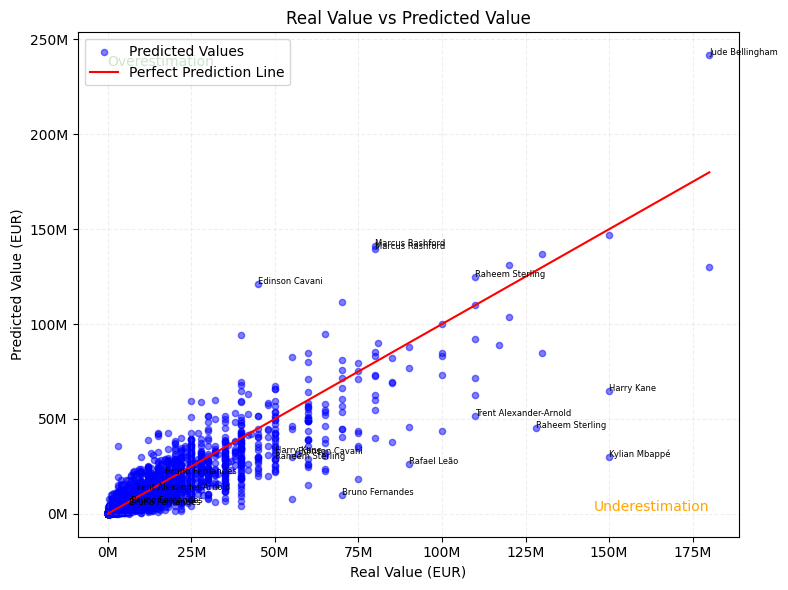

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# Calculate distances of each point from the optimal line
distances = np.abs(y_pred_original - y_test_original)

# Find the indices of points with maximum distances
max_distance_indices = np.argsort(distances)[-10:]  # Adjust the number to show more or fewer names

# Get the corresponding player names
furthest_names = z.iloc[max_distance_indices]['name'].tolist()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, s=20, color='blue', alpha=0.5, marker='o', label='Predicted Values')
plt.xlabel("Real Value (EUR)")
plt.ylabel("Predicted Value (EUR)")
plt.title("Real Value vs Predicted Value")
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', label='Perfect Prediction Line')
plt.text(min(y_test_original), max(y_pred_original), "Overestimation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test_original), min(y_pred_original), "Underestimation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')

# Annotate only the furthest points
for index, row in z.iterrows():
    if row['name'] in furthest_names:
        plt.annotate(row['name'], (row['market_value_in_eur'], row['Predicted_Value']), fontsize=6, color='black')

# Set formatter for x-axis and y-axis
def millions_formatter(x, pos):
    return f'{x / 1000000:.0f}M'

formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(alpha=0.2, linestyle='--', zorder=1)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(y_test, y_pred, s=20, color='blue', alpha=0.5)  # Set dot size to 20, blue color, and transparency to 0.5
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.title("Value vs Predicted value")

# Add diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.text(min(y_test), max(y_pred), "Over evaluation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test), min(y_pred), "Under evaluation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')
plt.grid(alpha=0.2, zorder=1)

plt.show()


In [ ]:
import numpy as np

# Calculate distances of each point from the optimal line
distances = np.abs(y_pred_original - y_test_original)

# Find the indices of points with maximum distances
max_distance_indices = np.argsort(distances)[-30:]  # Adjust the number to show more or fewer names

# Get the corresponding player names
furthest_names = z.iloc[max_distance_indices]['name'].tolist()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, s=20, color='blue', alpha=0.5, marker='o', label='Predicted Values')
plt.xlabel("True Value (EUR)")
plt.ylabel("Predicted Value (EUR)")
plt.title("True Value vs Predicted Value (XGBoost)")
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', label='Perfect Prediction Line')
plt.text(min(y_test_original), max(y_pred_original), "Overestimation", fontsize=10, color='green', verticalalignment='top', horizontalalignment='left')
plt.text(max(y_test_original), min(y_pred_original), "Underestimation", fontsize=10, color='orange', verticalalignment='bottom', horizontalalignment='right')

# Annotate only the furthest points
for index in max_distance_indices:
    row = z.iloc[index]
    plt.annotate(row['name'], (row['market_value_in_eur'], row['Predicted_Value']), fontsize=6, color='black')

# Set formatter for x-axis and y-axis
def millions_formatter(x, pos):
    return f'{x / 1000000:.0f}M'

# Identify the 1% most valuable players
top_1_percent = z.nlargest(int(len(z) * 0.05), 'market_value_in_eur')
top_1_percent = top_1_percent.sort_values(by='market_value_in_eur')
lowest_value_player = top_1_percent.iloc[0]['market_value_in_eur']
# Add vertical line for the 1% most valuable players
print(lowest_value_player)
plt.axvline(x=lowest_value_player, color='gray', linestyle='--', label='5% Most Valuable Players', alpha=0.5)
    
formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(alpha=0.2, linestyle='--', zorder=1)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
XGBRegressor.plot_importance(model)